In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
fs, data = wavfile.read('testseq.wav')

In [3]:
fs

16000

In [4]:
data

array([37, -2, 13, ..., -5,  7,  0], dtype=int16)

Text(0, 0.5, 'amplitude')

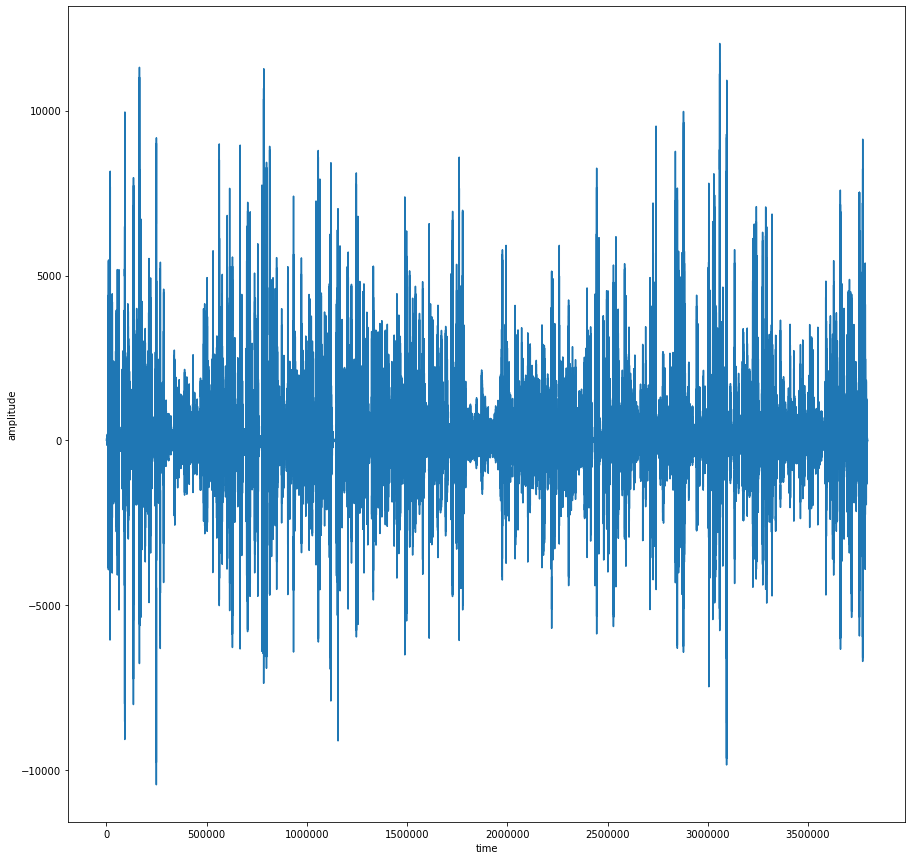

In [5]:
plt.figure(figsize=(15, 15))
plt.plot(range(data.shape[0]), data)
plt.xlabel('time')
plt.ylabel('amplitude')

## Forward backward algorithm

In [6]:
pi = np.array([0.2, 0.5, 0.3])
A = np.array([[0.6, 0.2, 0.2], [0.2, 0.6, 0.2], [0.2, 0.2, 0.6]])
B = np.array([[0.4, 0.3, 0.2, 0.1], [0.3, 0.2, 0.1, 0.4], [0.2, 0.1, 0.4, 0.3]])
obs = np.array([3, 0, 2, 0, 2, 0, 3, 1, 0, 1, 3, 1])

In [11]:
def forward(obs):
    # returns alpha
    # forward part of forward backward algorithm
    N = A.shape[0]
    T = len(obs)
    alpha = np.zeros((T, N))
    # calculating alpha_0
    alpha[0] = pi*B[:,obs[0]]
    # calculating alpha 1....T using alpha previously calculated, sort of dynamic programming
    for t in range(1, T):
        alpha[t] = alpha[t-1].dot(A) * B[:, obs[t]]
    return alpha

def likelihood(obs):
    # returns sum of forward part of forward backward algorithm
    z = forward(obs)[-1]
    return  z.sum()
def backward(obs):
    # returns beta
    # backward part of forward-backward algorithm
    N = A.shape[0]
    T = len(obs)
    beta = np.zeros((N,T))
    beta[:,-1:] = 1
    
    # calculating beta t-2 .... 0 using beta t-1, ... 1 sort of dp
    for t in reversed(range(T-1)):
        n = 0
        while n < N:
            beta[n,t] = np.sum(beta[:,t+1] * A[n,:] * B[:, obs[t+1]])
            n += 1

    return beta

def forward_backward(obs):
    # returns result of forward-backward algorithm
    alpha = forward(obs)
    beta  = backward(obs)
    obs = likelihood(obs)
    return (np.multiply(alpha,beta.T)/obs)



output = forward_backward(obs)
print("Output:")
print(output)

Output:
[[0.07885842 0.62904217 0.29209941]
 [0.32833234 0.38285851 0.28880915]
 [0.33892333 0.16641672 0.49465994]
 [0.42897394 0.22452807 0.34649799]
 [0.35348199 0.15644745 0.49007056]
 [0.37782499 0.33600433 0.28617068]
 [0.20037777 0.50325414 0.29636809]
 [0.45463718 0.40438633 0.14097649]
 [0.48978445 0.37468921 0.13552635]
 [0.45391565 0.4152269  0.13085744]
 [0.20801379 0.54318365 0.24880256]
 [0.4122664  0.4227798  0.16495381]]


### Posterior distribution of 1st state

In [15]:
posterior = np.array(output).ravel()
for i in range(12):
    print(f"{i}: {posterior[i]}")

0: 0.07885841938004934
1: 0.6290421697971287
2: 0.29209941082282187
3: 0.3283323406258614
4: 0.3828585126636325
5: 0.288809146710506
6: 0.3389233329043239
7: 0.1664167232442702
8: 0.49465994385140577
9: 0.4289739442115124
10: 0.22452806514281262
11: 0.3464979906456748


### Posterior distribution of 2nd state

In [17]:
for i in range(12, 24):
    print(f"{i-12}: {posterior[i]}")

0: 0.35348198543819903
1: 0.15644745325291232
2: 0.49007056130888843
3: 0.3778249922484669
4: 0.33600432644176653
5: 0.28617068130976653
6: 0.20037777400698117
7: 0.5032541389228905
8: 0.2963680870701283
9: 0.4546371812988519
10: 0.4043863286578292
11: 0.14097649004331889


### Posterior distribution for 3rd state

In [19]:
for i in range(24, 36):
    print(f"{i-24}: {posterior[i]}")

0: 0.48978444546903804
1: 0.374689209288711
2: 0.13552634524225093
3: 0.4539156506252166
4: 0.4152269048036352
5: 0.13085744457114823
6: 0.2080137890319948
7: 0.5431836505314173
8: 0.24880256043658813
9: 0.41226639709714175
10: 0.42277979526666315
11: 0.16495380763619516


## Finding speakers using HMM

In [22]:
fs, data = wavfile.read('testseq.wav')

In [24]:
mfcc_features = mfcc(data, fs)
filterbank_features = logfbank(data, fs)

In [28]:
mfcc_features.shape

(23727, 13)

In [26]:
print ('MFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])
print ('Filter bank:\nNumber of windows =', filterbank_features.shape[0])
print ('Length of each feature =', filterbank_features.shape[1])

MFCC:
Number of windows = 23727
Length of each feature = 13
Filter bank:
Number of windows = 23727
Length of each feature = 26


In [27]:
model = hmm.GaussianHMM(n_components=10)

In [29]:
model.fit(mfcc_features)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=10, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [34]:
prediction = model.predict(mfcc_features)

In [35]:
print(prediction.shape)

(23727,)


In [37]:
prediction

array([1, 1, 1, ..., 2, 2, 2])

In [40]:
endpoints = []
speaker = []
for i in range(1, len(prediction)):
    if Z[i] != Z[i-1]:
        # means speaker changed
        endpoints.append(i-1)
        speaker.append(Z[i-1])
endpoints.append(len(prediction) - 1)
speaker.append(Z[len(prediction) - 1])

### speaker list is:

In [41]:
speaker

[1,
 2,
 8,
 3,
 7,
 8,
 0,
 2,
 1,
 8,
 2,
 6,
 8,
 2,
 6,
 8,
 0,
 2,
 6,
 2,
 0,
 6,
 2,
 1,
 6,
 0,
 8,
 9,
 2,
 1,
 2,
 4,
 3,
 8,
 2,
 0,
 8,
 9,
 4,
 2,
 1,
 8,
 2,
 1,
 2,
 3,
 8,
 6,
 8,
 7,
 4,
 2,
 4,
 9,
 4,
 2,
 1,
 6,
 2,
 1,
 2,
 0,
 2,
 6,
 1,
 2,
 5,
 2,
 5,
 7,
 9,
 2,
 1,
 5,
 2,
 1,
 6,
 2,
 1,
 0,
 5,
 2,
 5,
 6,
 5,
 7,
 4,
 7,
 5,
 7,
 2,
 1,
 6,
 1,
 5,
 7,
 4,
 2,
 6,
 1,
 2,
 5,
 2,
 6,
 1,
 2,
 4,
 9,
 7,
 2,
 1,
 6,
 1,
 2,
 7,
 2,
 6,
 5,
 2,
 1,
 5,
 2,
 6,
 5,
 9,
 2,
 1,
 4,
 2,
 1,
 6,
 2,
 1,
 9,
 2,
 5,
 7,
 2,
 6,
 9,
 4,
 2,
 1,
 2,
 8,
 5,
 7,
 4,
 2,
 1,
 6,
 2,
 6,
 8,
 5,
 2,
 5,
 2,
 7,
 4,
 2,
 1,
 2,
 8,
 5,
 0,
 6,
 4,
 2,
 1,
 6,
 1,
 5,
 7,
 9,
 2,
 7,
 2,
 1,
 2,
 8,
 2,
 6,
 5,
 2,
 1,
 2,
 1,
 2,
 5,
 2,
 6,
 5,
 2,
 1,
 4,
 9,
 6,
 1,
 2,
 4,
 2,
 6,
 1,
 6,
 2,
 6,
 5,
 7,
 4,
 2,
 1,
 5,
 7,
 9,
 7,
 2,
 1,
 9,
 7,
 2,
 1,
 2,
 5,
 2,
 1,
 2,
 5,
 6,
 1,
 2,
 4,
 7,
 5,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 7,
 2,
 6,
 2,
 0,
 2,
 6,
 2,
 0,


In [42]:
endpoints

[49,
 53,
 61,
 67,
 73,
 76,
 96,
 97,
 105,
 124,
 125,
 136,
 161,
 164,
 174,
 178,
 185,
 187,
 191,
 198,
 222,
 237,
 239,
 241,
 247,
 251,
 265,
 268,
 273,
 276,
 277,
 282,
 284,
 290,
 293,
 301,
 306,
 309,
 310,
 311,
 313,
 318,
 319,
 326,
 328,
 339,
 343,
 354,
 359,
 362,
 365,
 369,
 376,
 390,
 399,
 401,
 409,
 414,
 419,
 481,
 482,
 490,
 493,
 499,
 510,
 514,
 525,
 532,
 545,
 559,
 577,
 578,
 584,
 589,
 591,
 592,
 603,
 604,
 607,
 610,
 618,
 624,
 632,
 647,
 648,
 653,
 662,
 667,
 677,
 688,
 689,
 692,
 699,
 701,
 710,
 712,
 723,
 724,
 732,
 738,
 755,
 777,
 781,
 797,
 826,
 830,
 836,
 844,
 846,
 847,
 850,
 856,
 859,
 862,
 868,
 872,
 885,
 896,
 897,
 905,
 914,
 918,
 927,
 934,
 944,
 948,
 954,
 964,
 969,
 998,
 1009,
 1011,
 1020,
 1039,
 1042,
 1046,
 1055,
 1056,
 1068,
 1078,
 1083,
 1084,
 1089,
 1095,
 1101,
 1108,
 1110,
 1121,
 1122,
 1125,
 1130,
 1135,
 1148,
 1154,
 1160,
 1167,
 1192,
 1197,
 1203,
 1227,
 1229,
 1269,
 127

In [43]:
data.shape

(3796513,)

In [44]:
# 301 endpoints
datapoints = data.reshape((301, 12613))

In [46]:
parameters = set(datapoints.ravel())
mdl = hmm.GaussianHMM(n_components=10, params=parameters)

In [47]:
mdl.fit(datapoints)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=10, n_iter=10,
            params={-10448, -10378, -9847, -9771, -9648, -9640, -9622, -9597,
                    -9582, -9485, -9482, -9461, -9440, -9365, -9330, -9294,
                    -9198, -9194, -9152, -9149, -9117, -9102, -9086, -9075,
                    -9062, -9050, -9013, -9005, -9002, -9000, ...},
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [48]:
predictions = mdl.predict(datapoints)

In [49]:
predictions.shape

(301,)

In [51]:
print(predictions)

[1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 1 1 1 1 1 1 9 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


In [52]:
# printing speaker number and times for which a particular speaker speaks
count = 0
start = 0
# 301 endpoints
for i in range(301):
    if i == endpoints[count]:
        end = i*238/301
        # 238 sec audio
        print("Speaker: ", speaker[count], "| Time duration: ", np.round(start,4)," - ",np.round(end,4),"secs")
        start = end
        count += 1
print("Speaker: ", speaker[count], "| Time duration: ", np.round(start,4)," - ",np.round(end,4),"secs")

Speaker:  1 | Time duration:  0  -  38.7442 secs
Speaker:  2 | Time duration:  38.7442  -  41.907 secs
Speaker:  8 | Time duration:  41.907  -  48.2326 secs
Speaker:  3 | Time duration:  48.2326  -  52.9767 secs
Speaker:  7 | Time duration:  52.9767  -  57.7209 secs
Speaker:  8 | Time duration:  57.7209  -  60.093 secs
Speaker:  0 | Time duration:  60.093  -  75.907 secs
Speaker:  2 | Time duration:  75.907  -  76.6977 secs
Speaker:  1 | Time duration:  76.6977  -  83.0233 secs
Speaker:  8 | Time duration:  83.0233  -  98.0465 secs
Speaker:  2 | Time duration:  98.0465  -  98.8372 secs
Speaker:  6 | Time duration:  98.8372  -  107.5349 secs
Speaker:  8 | Time duration:  107.5349  -  127.3023 secs
Speaker:  2 | Time duration:  127.3023  -  129.6744 secs
Speaker:  6 | Time duration:  129.6744  -  137.5814 secs
Speaker:  8 | Time duration:  137.5814  -  140.7442 secs
Speaker:  0 | Time duration:  140.7442  -  146.2791 secs
Speaker:  2 | Time duration:  146.2791  -  147.8605 secs
Speaker: 